In [420]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [421]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle
import csv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

import utils
from utils import moving_average, SimpleDataset
from solve_binary_libsvm import solve_binary_libsvm

import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

import scipy
import svmlight_loader

import lightning as L
import torchmetrics

from pt_methods import TwinPolyakMA, Momo
import sps

from custom_logger import DBLogger

from dotenv import load_dotenv
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [422]:
device = torch.device('cpu')
device

device(type='cpu')

In [423]:
train_data, train_target = sklearn.datasets.load_svmlight_file(f'{os.getenv("LIBSVM_DIR")}/covtype.libsvm.binary.scale')



In [446]:
import sklearn.model_selection
import sklearn.preprocessing

class CovtypeBinaryDataModule(L.LightningDataModule):
    
    def __init__(self, data_dir: str = os.getenv("LIBSVM_DIR"), batch_size: int = 32):
        super().__init__()
        
        data, target = sklearn.datasets.load_svmlight_file(f'{data_dir}/covtype.libsvm.binary.scale')
        data = sklearn.preprocessing.normalize(data, norm='l2', axis=1)
        target = (target - 1).astype(np.float32)

        assert np.all(np.sort(np.unique(target)) == [0.0, 1.0])

        self.train_data, self.val_data, self.train_target, self.val_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

        self.batch_size: int = batch_size
        self.num_features: int = 54
        self.num_labels: int = 2

    def setup(self, stage: str):
        
        if stage  == 'fit':
            self.train_dataset = SimpleDataset(self.train_data, self.train_target)
            self.val_dataset = SimpleDataset(self.val_data, self.val_target)
        if stage == 'test':
            self.val_dataset = SimpleDataset(self.val_data, self.val_target)
        if stage == 'predict':
            self.val_dataset = SimpleDataset(self.val_data, self.val_target)
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self._sparse_collate, num_workers=4, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self._sparse_collate, num_workers=4, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self._sparse_collate, num_workers=4, shuffle=False)
    
    
    def _sparse_coo_to_tensor(self, coo):
        values = coo.data
        indices = np.vstack((coo.row, coo.col))
        shape = coo.shape
        
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        s = torch.Size(shape)
        
        return torch.sparse_coo_tensor(i, v, s)

    def _sparse_collate(self, batch):
        xs, ys = zip(*batch)
        
        xs = scipy.sparse.vstack(xs).tocoo()
        xs = self._sparse_coo_to_tensor(xs)
        
        return xs, torch.tensor(ys, dtype=torch.float32).unsqueeze(1)

In [451]:
optimizers_dict = {
    'Adam': torch.optim.Adam,
    'Momo': Momo,
    'SPS': sps.Sps,
    'Adagrad': torch.optim.Adagrad,
}

from abc import ABC, abstractmethod

class LinearBinaryModel(nn.Module):
    
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1)
        
    def forward(self, x):
        return self.linear(x)

class BaseTrainingModule(L.LightningModule, ABC):
    
    def __init__(self, config: dict):
        super().__init__()

        self.optimizer = config['optimizer']
        self.optimizer_hparams = config['optimizer_hparams']

        if self.optimizer == "STP":
            self.automatic_optimization = False
            self.model_x = self.build_model()
            self.model_y = self.build_model()
        else:    
            self.model = self.build_model()
        
        self.loss_fn = self.define_loss_fn()
        self.val_acc = self.define_val_acc_metric()

    @abstractmethod
    def define_loss_fn(self, *args, **kwargs):
        pass

    @abstractmethod
    def define_val_acc_metric(self, *args, **kwargs):
        pass

    @abstractmethod
    def build_model(self, *args, **kwargs):
        pass

    @abstractmethod
    def unpack_batch(self, batch):
        pass

    def training_step(self, batch):
        x, y = self.unpack_batch(batch)

        if self.optimizer == 'STP':
            logits_x = self.model_x(x)
            logits_y = self.model_y(x)

            loss_x = self.loss_fn(logits_x, y)
            loss_y = self.loss_fn(logits_y, y)

            optimizer_x = self.optimizers()[0]
            optimizer_y = self.optimizers()[1]

            optimizer_x.zero_grad()
            optimizer_y.zero_grad()

            h_x = optimizer_x.momentum_step(loss_x)
            h_y = optimizer_y.momentum_step(loss_y)

            if h_x > h_y:
                loss_diff = h_x - h_y
                optimizer_x.step(loss_diff=loss_diff)
                self.log('train_loss', loss_x, on_step=False, on_epoch=True)
                self.log('lr', optimizer_x.step_size.item())
            else:
                loss_diff = h_y - h_x
                optimizer_y.step(loss_diff=loss_diff)
                self.log('train_loss', loss_y, on_step=False, on_epoch=True)
                self.log('lr', optimizer_y.step_size.item(), on_step=True, on_epoch=False)
        else:
            logits = self.model(x)
            loss = self.loss_fn(logits, y)            
            
            self.log('train_loss', loss, on_step=False, on_epoch=True)

            return loss
        
    def on_train_batch_end(self, *args, **kwargs):
        if isinstance(self.optimizers(), Momo):
            self.log('lr', self.optimizers().state['step_size_list'][-1], on_step=True, on_epoch=False)
        elif isinstance(self.optimizers(), sps.Sps):
            self.log('lr', self.optimizers().state['step_size'], on_step=True, on_epoch=False)
        elif self.optimizer == "STP":
            pass
        else:
            self.log('lr', self.optimizers().param_groups[0]["lr"], on_step=True, on_epoch=False)
        
    def validation_step(self, batch):
        x, y = batch
        x = x.to_dense()
        y = y.to_dense()

        if self.optimizer == "STP":
            logits_x = self.model_x(x)
            logits_y = self.model_y(x)

            loss_x = self.loss_fn(logits_x, y)
            loss_y = self.loss_fn(logits_y, y)

            if loss_x < loss_y:
                self.val_acc(logits_x, y)
                self.log('val_loss', loss_x, on_step=False, on_epoch=True)
                if self.val_acc is not None:
                    self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
            else:
                self.val_acc(logits_y, y)
                self.log('val_loss', loss_y, on_step=False, on_epoch=True)
                if self.val_acc is not None:
                    self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)

        else:
            logits = self.model(x)
            loss = self.loss_fn(logits, y)
            self.log('val_loss', loss, on_step=False, on_epoch=True)
            
            if self.val_acc is not None:
                self.val_acc(logits, y)
                self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        
        
    def configure_optimizers(self):
        optimizer = self.hparams['config']['optimizer']
        optimizer_hparams = self.hparams['config']['optimizer_hparams']
        if optimizer == "STP":
            return [TwinPolyakMA(self.model_x.parameters(), **optimizer_hparams),
                    TwinPolyakMA(self.model_y.parameters(), **optimizer_hparams)]
        else:
            optimizer = optimizers_dict[optimizer](self.model.parameters(), **optimizer_hparams)
            return [optimizer]
        

class CovtypeBinaryClassifier(BaseTrainingModule):

    def __init__(self, input_dim: int, config: dict):

        self.input_dim = input_dim
        

        self.save_hyperparameters(
            {
                'dataset': 'covtype.binary',
                'task': 'binary-classification',
                'model': 'linear',
                'config': config,
            }
        )

        super().__init__(config)
        
    def build_model(self):
        return LinearBinaryModel(self.input_dim)

    def define_loss_fn(self):
        return nn.BCEWithLogitsLoss()
    
    def define_val_acc_metric(self):
        return torchmetrics.classification.BinaryAccuracy()
    
    def unpack_batch(self, batch):
        x, y = batch
        return x.to_dense(), y.to_dense()

In [452]:
data_module = CovtypeBinaryDataModule(batch_size=128)
data_module.setup('fit')


for x, y in data_module.train_dataloader():
    print(x.to_dense().shape)
    print(y.to_dense().shape)
    break

torch.Size([128, 54])
torch.Size([128, 1])


In [455]:
from lightning.pytorch import Trainer, seed_everything, loggers

seed = 0

config = {
    'seed': seed,
    'max_epochs': 10,
    'batch_size': 4096,
    'optimizer': 'Adagrad',
    'optimizer_hparams': {
        'lr': 0.01,
    },
}

data_module = CovtypeBinaryDataModule(batch_size=config['batch_size'])
data_module.setup('fit')

seed_everything(seed, workers=True)

model = CovtypeBinaryClassifier(input_dim=data_module.num_features, config=config)

db_logger_callback = DBLogger()
csv_logger = loggers.CSVLogger(
    save_dir=f"logs/{model.hparams['dataset']}",
    version=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

trainer = L.Trainer(
    max_epochs=config['max_epochs'], 
    logger=[csv_logger], 
    callbacks=[db_logger_callback], 
    accelerator='cpu',
    log_every_n_steps=min(len(data_module.train_dataloader()), 50)
    )

trainer.fit(model=model, datamodule=data_module)

Seed set to 0
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: False
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | LinearBinaryModel | 55     | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | val_acc | BinaryAccuracy    | 0      | train
------------------------------------------------------
55        Trainable params
0         Non-trainable params
55        Total params
0.000     Total estimated model params size (MB)

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
`Trainer.fit` stopped: `max_epochs=10` reached.


12

In [ ]:
import pandas as pd 
from functools import reduce
import operator

db = pd.read_csv('experiments_db.csv')

db['optimizer_hparams'] = db['optimizer_hparams'].apply(json.loads)

seeds = [0, 1, 2, 3, 4]

query = {
    'dataset': 'yeast',
    'optimizer': "Adagrad",
}

lrs = [2**x for x in range(-20, 20)]

optimizer_hparams = {
        'lr': lrs[5]
}

mask = reduce(operator.and_, [(db[k] == v) for k, v in query.items()])

seed_mask = db['seed'].isin(seeds)
mask = mask & seed_mask

def match_hparams(row_hparams, query_hparams):
    return all(row_hparams.get(k) == v for k, v in query_hparams.items())

filtered = db[mask]
filtered = filtered[filtered['optimizer_hparams'].apply(
    lambda row_hparams: match_hparams(row_hparams, optimizer_hparams)
)]

filtered

,run_id,start_time,end_time,seed,dataset,batch_size,task,model,max_epochs,optimizer,optimizer_hparams,metrics_path,hp_lr,hp_beta
205,ee5d3abc-0f75-467a-8454-717029460828,2025-06-03T13:45:12.621890,2025-06-03T13:45:37.118236,0,yeast,128,multi-label-classification,linear,50,Adagrad,{'lr': 3.0517578125e-05},logs/yeast/lightning_logs/20250603-134512,0.000031,NaN
248,1cc55f14-64ba-4397-b8ec-410c6453e0d4,2025-06-03T14:02:24.107626,2025-06-03T14:02:48.951866,1,yeast,128,multi-label-classification,linear,50,Adagrad,{'lr': 3.0517578125e-05},logs/yeast/lightning_logs/20250603-140224,0.000031,NaN
288,e67fd090-c0df-44fe-b03a-73347e68eab5,2025-06-03T14:19:22.557640,2025-06-03T14:19:47.018770,2,yeast,128,multi-label-classification,linear,50,Adagrad,{'lr': 3.0517578125e-05},logs/yeast/lightning_logs/20250603-141922,0.000031,NaN
328,a64d9f6d-c49f-42c8-a6af-35ad99f47dfe,2025-06-03T14:36:15.375608,2025-06-03T14:36:40.543546,3,yeast,128,multi-label-classification,linear,50,Adagrad,{'lr': 3.0517578125e-05},logs/yeast/lightning_logs/20250603-143615,0.000031,NaN
368,20014f83-d855-4924-afdc-e67066de911d,2025-06-03T14:53:30.811142,2025-06-03T14:53:56.136134,4,yeast,128,multi-label-classification,linear,50,Adagrad,{'lr': 3.0517578125e-05},logs/yeast/lightning_logs/20250603-145330,0.000031,NaN


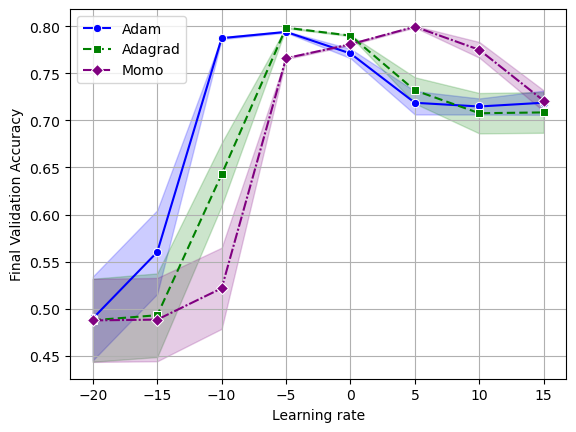

In [323]:
import seaborn as sns

db = pd.read_csv('experiments_db.csv')

db['optimizer_hparams'] = db['optimizer_hparams'].apply(json.loads)

seeds = [0, 1, 2, 3, 4]

query = {
    'dataset': 'yeast',
}

lrs = [2**x for x in range(-20, 20)]

mask = reduce(operator.and_, [(db[k] == v) for k, v in query.items()])

seed_mask = db['seed'].isin(seeds)
mask = mask & seed_mask

filtered = db[mask]

def load_final_val_acc(metrics_path):
    try:
        metrics_file = os.path.join(metrics_path, 'metrics.csv')
        metrics = pd.read_csv(metrics_file)
        val_acc = metrics['val_acc'].dropna().iloc[-1]
        return val_acc
    except Exception as e:
        print(f"[ERROR]: Failed to load from {metrics_path}: {e}")
        return None
    
def load_final_val_loss(metrics_path):
    try:
        metrics_file = os.path.join(metrics_path, 'metrics.csv')
        metrics = pd.read_csv(metrics_file)
        val_loss = metrics['val_loss'].dropna().iloc[-1]
        return val_loss
    except Exception as e:
        print(f"[ERROR]: Failed to load from {metrics_path}: {e}")
        return None


filtered['val_acc'] = filtered['metrics_path'].apply(load_final_val_acc)
filtered['val_loss'] = filtered['metrics_path'].apply(load_final_val_loss)
filtered['lr_exp'] = np.log2(filtered['hp_lr'])


summary = (
    filtered.groupby(['optimizer', 'hp_lr'])
    .agg(val_acc_mean=('val_acc', 'mean'),
         val_acc_std=('val_acc', 'std'))
    .reset_index()
)

lrs_range = filtered['lr_exp'].dropna().unique()

# stp_val_acc = filtered[filtered['optimizer'] == 'STP']['val_acc']
# plt.plot(lrs_range[::5], [stp_val_acc.mean() for _ in range(len(lrs_range[::5]))], label="STP")
# plt.fill_between(lrs_range[::5], stp_val_acc.mean() - stp_val_acc.std(), stp_val_acc.mean() + stp_val_acc.std(), alpha=0.2)

palette = {
    'Adam': 'blue',
    'Adagrad': 'green',
    'Momo': 'purple',
}

linestyles = {
    'Adam': (1, 0),
    'Adagrad': (4, 2),
    'Momo': (5, 1, 1, 1),
}

markers = {
    'Adam': 'o',
    'Adagrad': 's',
    'Momo': 'D',
}


sns.lineplot(
    data=filtered[filtered['optimizer'] != 'STP'][::5],
    x='lr_exp',
    y='val_acc',
    hue='optimizer',
    style='optimizer',
    markers=markers,
    dashes=linestyles,
    palette=palette,
    errorbar='sd',
)

plt.xlabel('Learning rate')
plt.ylabel('Final Validation Accuracy')
# plt.xticks(ticks=range(-20, 20, 5), labels=[f'$2^{{{x}}}$' for x in range(-20, 20, 5)])
plt.legend()
plt.grid()
plt.show()

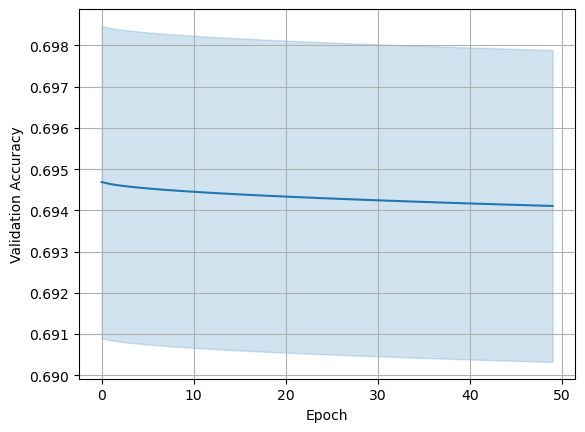

In [ ]:
sns.lineplot(
    data=results_df,
    x='epoch',
    y='train_loss',
    errorbar='sd',
    
)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()